# Problem-3

In [ ]:
!apt-get install -y swig
!pip install box2d-py


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (1,388 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 123623 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubu

In [ ]:
pip install stable-baselines3[extra] gymnasium[box2d] box2d-py

  Using cached box2d-py-2.3.8.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached Shimmy-1.3.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached AutoROM-0.6.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached swig-4.2.1.post0-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl.metadata (3.5 kB)
  Using cached AutoROM.accept_rom_license-0.6.1-py3-none-any.whl
  Using cached ale_py-0.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
Using cached swig-4.2.1.post0-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.8 MB)
Using cached AutoROM-0.6.1-py3-none-any.whl (9.4 kB)
Using cached Shimmy-1.3.0-py3-none-any.whl (37 kB)
Using cached ale_py-0.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.7 MB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See abov

## a)

In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO

# Create the LunarLander-v2 environment
env = gym.make("LunarLander-v2")

# Initialize the PPO agent with the environment
model = PPO("MlpPolicy", env, verbose=1)

# Train the agent for a specific number of timesteps
timesteps = 10000
model.learn(total_timesteps=timesteps)

# Save the trained model
model.save("ppo_lunarlander")

# Load the model
model = PPO.load("ppo_lunarlander")

# Test the trained agent
obs, _ = env.reset()
done = False
total_reward = 0

while not done:
    # Predict the next action
    action, _ = model.predict(obs, deterministic=True)
    # Take the action in the environment
    obs, reward, done, truncated, info = env.step(action)
    total_reward += reward
    env.render()

print("Total reward after testing:", total_reward)

# Close the environment after testing
env.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93       |
|    ep_rew_mean     | -217     |
| time/              |          |
|    fps             | 603      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 97.3         |
|    ep_rew_mean          | -198         |
| time/                   |              |
|    fps                  | 316          |
|    iterations           | 2            |
|    time_elapsed         | 12           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0064532645 |
|    clip_fraction        | 0.00903      |
|    clip_range           | 0.2          |
|    en

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/box2d/lunar_lander.py:681: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("LunarLander-v2", render_mode="rgb_array")
  gym.logger.warn(


## b)

In [ ]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=-1)

# Function to compute rewards-to-go
def compute_rewards_to_go(rewards, gamma=0.99):
    rewards_to_go = np.zeros_like(rewards)
    running_sum = 0
    for t in reversed(range(len(rewards))):
        running_sum = rewards[t] + gamma * running_sum
        rewards_to_go[t] = running_sum
    return rewards_to_go

# Function for advantage normalization
def normalize_advantages(advantages):
    return (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)

# Training function for policy gradient
def train_policy_gradient(env_name, num_iterations=1000, batch_size=100, gamma=0.99, use_reward_to_go=False, use_adv_norm=False):
    env = gym.make(env_name)
    policy = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
    optimizer = optim.Adam(policy.parameters(), lr=1e-2)

    rewards_list = []  # List to store rewards for plotting

    for iteration in range(num_iterations):
        states, actions, rewards = [], [], []
        total_reward = 0
        state = env.reset()
        done = False

        # Generate an episode
        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = policy(state_tensor)
            action = np.random.choice(env.action_space.n, p=action_probs.detach().numpy())

            next_state, reward, done, _ = env.step(action)
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            total_reward += reward
            state = next_state

        # Compute rewards-to-go or use total reward
        if use_reward_to_go:
            rewards_to_go = compute_rewards_to_go(rewards, gamma)
        else:
            rewards_to_go = [total_reward] * len(rewards)

        # Normalize advantages if needed
        if use_adv_norm:
            rewards_to_go = normalize_advantages(rewards_to_go)

        # Convert lists to PyTorch tensors
        states_tensor = torch.tensor(states, dtype=torch.float32)
        actions_tensor = torch.tensor(actions, dtype=torch.int64)
        rewards_tensor = torch.tensor(rewards_to_go, dtype=torch.float32)

        # Compute loss
        action_log_probs = torch.log(policy(states_tensor).gather(1, actions_tensor.view(-1, 1)).squeeze())
        loss = -(action_log_probs * rewards_tensor).mean()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        rewards_list.append(total_reward)  # Track total reward for plotting

        if iteration+1%100==0:
          print(f"Iteration {iteration + 1}/{num_iterations}, Total Reward: {total_reward:.2f}")

    env.close()
    return rewards_list

# CartPole-v0

Training with use_reward_to_go=True and use_adv_norm=True
Training with use_reward_to_go=True and use_adv_norm=False
Training with use_reward_to_go=False and use_adv_norm=True
Training with use_reward_to_go=False and use_adv_norm=False


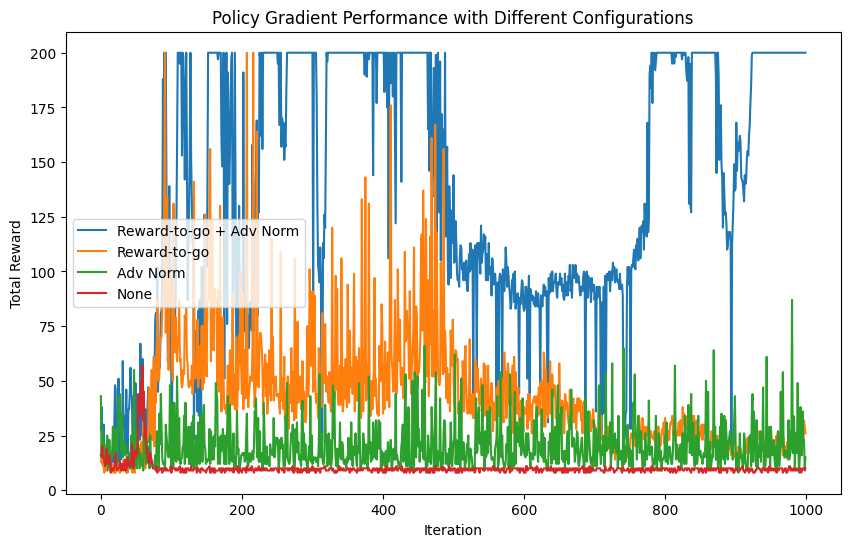

In [ ]:


# Run for different configurations and store results
configs = [(True, True), (True, False), (False, True), (False, False)]
config_labels = ["Reward-to-go + Adv Norm", "Reward-to-go", "Adv Norm", "None"]

all_rewards = []

for config in configs:
    use_reward_to_go, use_adv_norm = config
    print(f"Training with use_reward_to_go={use_reward_to_go} and use_adv_norm={use_adv_norm}")
    rewards = train_policy_gradient('CartPole-v0', num_iterations=1000, use_reward_to_go=use_reward_to_go, use_adv_norm=use_adv_norm)
    all_rewards.append(rewards)

# Plot the results
plt.figure(figsize=(10, 6))
for rewards, label in zip(all_rewards, config_labels):
    plt.plot(rewards, label=label)

plt.xlabel('Iteration')
plt.ylabel('Total Reward')
plt.title('Policy Gradient Performance with Different Configurations')
plt.legend()
plt.show()


Training with batch_size=50
Training with batch_size=100
Training with batch_size=500
Training with batch_size=1000


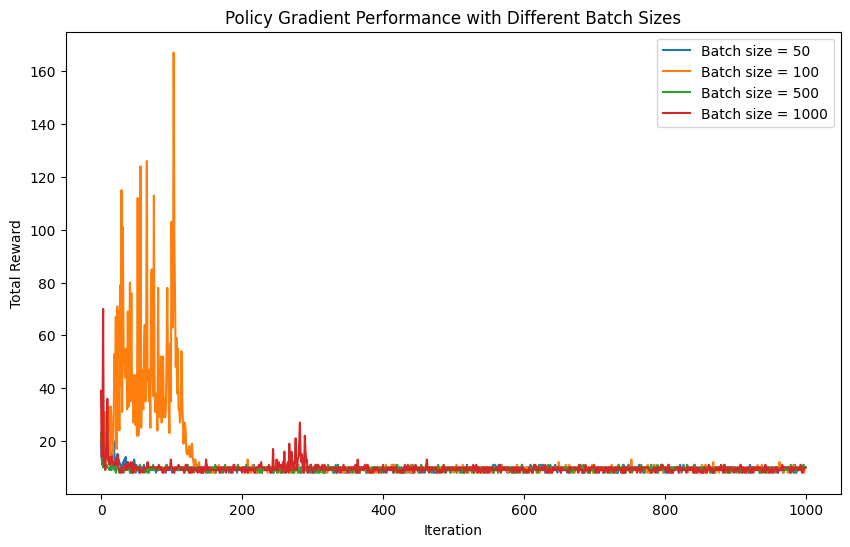

In [ ]:
# Run for different batch sizes and store results
batch_sizes = [50,100,500,1000]
batch_size_labels = [f"Batch size = {batch}" for batch in batch_sizes]

all_rewards_batch_sizes = []

for batch_size in batch_sizes:
    print(f"Training with batch_size={batch_size}")
    rewards = train_policy_gradient('CartPole-v0', num_iterations=1000, batch_size=batch_size)
    all_rewards_batch_sizes.append(rewards)

# Plot the results for different batch sizes
plt.figure(figsize=(10, 6))
for rewards, label in zip(all_rewards_batch_sizes, batch_size_labels):
    plt.plot(rewards, label=label)

plt.xlabel('Iteration')
plt.ylabel('Total Reward')
plt.title('Policy Gradient Performance with Different Batch Sizes')
plt.legend()
plt.show()

# Performance Analysis of Policy Gradient Algorithm on CartPole-v0 Environment

### Analysis of Different Configurations
In the second graph, we compare different configurations: "Reward-to-go" (RTG), "Advantage Normalization" (Adv Norm), both combined (RTG + Adv Norm), and neither.

1. **Reward-to-Go + Advantage Normalization**:
   - This combination shows the best performance with high reward peaks and more consistent performance as training progresses.
   - Both reward-to-go and advantage normalization help to reduce variance in policy gradient estimates, leading to more stable updates.

2. **Reward-to-Go Only**:
   - Using only the reward-to-go results in moderate performance, with reward values fluctuating but not as consistently high as the combined setup.
   - Reward-to-go helps in reducing the variance of gradient estimates but is less effective without normalization.

3. **Advantage Normalization Only**:
   - Advantage normalization alone provides some improvement over the baseline (None) but does not perform as well as the reward-to-go setup.
   - It helps in stabilizing the learning by normalizing the advantage estimates but lacks the impact of RTG in boosting rewards.

4. **None**:
   - Without reward-to-go or advantage normalization, the rewards remain low throughout the iterations, showing limited improvement in performance.
   - This demonstrates that both variance reduction techniques are crucial for effective learning in policy gradient methods.

### Analysis of Batch Size Impact
In the first graph, we observe the effect of different batch sizes (50, 100, 500, and 1000) on the total reward over iterations:

1. **Smaller Batch Sizes (50, 100)**:
   - Smaller batch sizes lead to higher variance in total rewards, with rewards oscillating considerably in the initial training phases.
   - The model stabilizes quicker, with rewards plateauing after around 200 iterations.
   - The instability suggests that smaller batches may introduce more noise into the gradient estimates, making it harder to converge smoothly.

2. **Larger Batch Sizes (500, 1000)**:
   - Larger batch sizes show an initial spike in reward but then stabilize around a lower range.
   - While the learning curve appears more stable and consistent, the overall rewards are lower than with smaller batch sizes.
   - This may be due to the fact that larger batch sizes provide more accurate gradient estimates but at the cost of slower updates.

3. **Optimal Batch Size**:
   - Based on this chart, smaller batch sizes tend to perform better initially in terms of achieving higher rewards, but they may suffer from instability.
   - For stable performance, larger batch sizes are preferable, as they result in less variance.


### Summary
In conclusion, for the CartPole-v0 environment:
- Smaller batch sizes offer quicker but noisier updates, while larger batch sizes provide more stable but slower progress.
- The combination of reward-to-go and advantage normalization produces the best results, showing that these techniques effectively stabilize learning and improve reward performance in policy gradient methods.
- To achieve stable and high rewards, both reward-to-go and advantage normalization should be applied in the policy gradient algorithm.


# LunarLander-v2

Training with use_reward_to_go=True and use_adv_norm=True
Training with use_reward_to_go=True and use_adv_norm=False
Training with use_reward_to_go=False and use_adv_norm=True
Training with use_reward_to_go=False and use_adv_norm=False


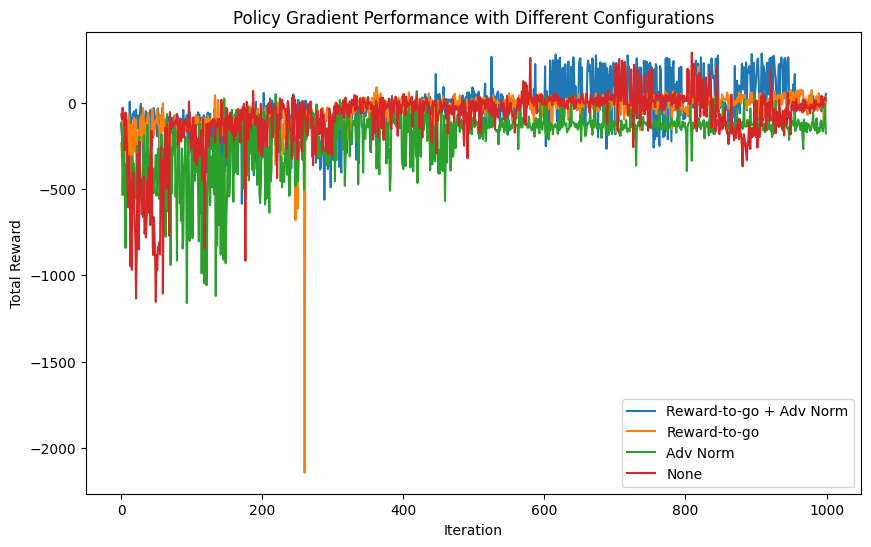

In [ ]:
# Run for different configurations and store results
configs = [(True, True), (True, False), (False, True), (False, False)]
config_labels = ["Reward-to-go + Adv Norm", "Reward-to-go", "Adv Norm", "None"]

all_rewards = []

for config in configs:
    use_reward_to_go, use_adv_norm = config
    print(f"Training with use_reward_to_go={use_reward_to_go} and use_adv_norm={use_adv_norm}")
    rewards = train_policy_gradient('LunarLander-v2', num_iterations=1000, use_reward_to_go=use_reward_to_go, use_adv_norm=use_adv_norm)
    all_rewards.append(rewards)

# Plot the results
plt.figure(figsize=(10, 6))
for rewards, label in zip(all_rewards, config_labels):
    plt.plot(rewards, label=label)

plt.xlabel('Iteration')
plt.ylabel('Total Reward')
plt.title('Policy Gradient Performance with Different Configurations')
plt.legend()
plt.show()

Training with batch_size=10
Training with batch_size=100
Training with batch_size=1000
Training with batch_size=5000


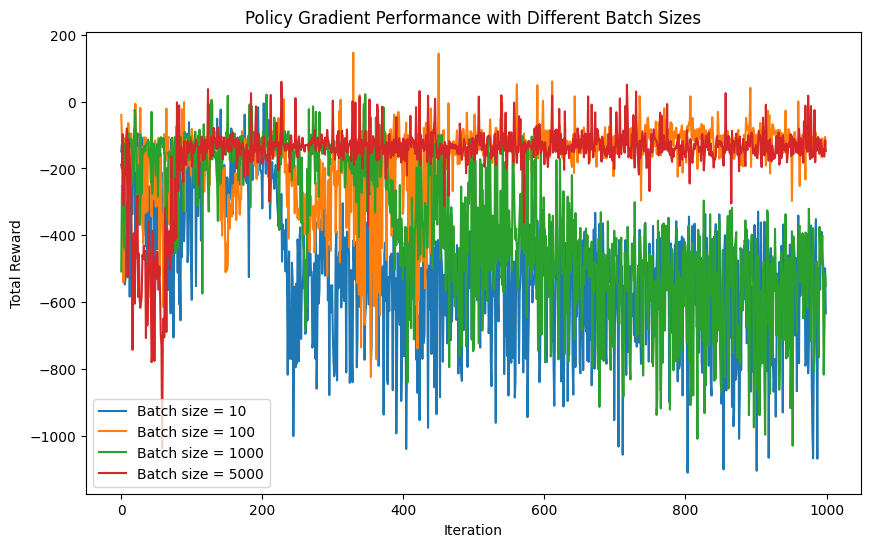

In [ ]:
# Run for different batch sizes and store results
batch_sizes = [10, 100,1000]
batch_size_labels = [f"Batch size = {batch}" for batch in batch_sizes]

all_rewards_batch_sizes = []

for batch_size in batch_sizes:
    print(f"Training with batch_size={batch_size}")
    rewards = train_policy_gradient('LunarLander-v2', num_iterations=1000, batch_size=batch_size)
    all_rewards_batch_sizes.append(rewards)

# Plot the results for different batch sizes
plt.figure(figsize=(10, 6))
for rewards, label in zip(all_rewards_batch_sizes, batch_size_labels):
    plt.plot(rewards, label=label)

plt.xlabel('Iteration')
plt.ylabel('Total Reward')
plt.title('Policy Gradient Performance with Different Batch Sizes')
plt.legend()
plt.show()

# Performance Analysis of Policy Gradient Algorithm on LunarLander-v2 Environment

### Analysis of Different Configurations
In the first graph, we compare different configurations: "Reward-to-go" (RTG), "Advantage Normalization" (Adv Norm), both combined (RTG + Adv Norm), and neither.

1. **Reward-to-Go + Advantage Normalization**:
   - This configuration exhibits the highest performance, showing consistent improvements in total rewards as training progresses.
   - The combination of reward-to-go and advantage normalization effectively reduces the variance in policy gradient estimates, leading to more stable updates and better long-term rewards.

2. **Reward-to-Go Only**:
   - The reward-to-go setup performs moderately well, demonstrating improvements over the baseline but not as pronounced as when combined with advantage normalization.
   - Although reward-to-go helps reduce variance by more precisely attributing rewards to actions, it can still result in some fluctuations without normalization.

3. **Advantage Normalization Only**:
   - Using only advantage normalization results in smoother learning compared to using neither method, but it underperforms relative to the reward-to-go configuration.
   - It helps stabilize training by centering the advantage estimates but lacks the more focused reward distribution provided by RTG.

4. **None**:
   - Without using either reward-to-go or advantage normalization, the rewards remain low and exhibit high variance throughout training.
   - This demonstrates that these variance reduction techniques are essential for effective training and performance in policy gradient algorithms.

### Analysis of Batch Size Impact
In the second graph, we observe the effect of different batch sizes (e.g., 10, 100, 1000, 5000) on total rewards across iterations:

1. **Smaller Batch Sizes (e.g., 10, 100)**:
   - Smaller batch sizes introduce higher variability in total rewards, with greater fluctuations during training.
   - While learning progresses more quickly, these batches can produce noisier gradient estimates, leading to unstable training.

2. **Larger Batch Sizes (e.g., 1000, 5000)**:
   - Larger batch sizes demonstrate steadier and more consistent learning curves with reduced reward variance.
   - Though they provide more reliable gradient estimates, the learning process may slow down, showing more gradual improvements.

3. **Optimal Batch Size**:
   - Smaller batch sizes may reach higher rewards faster but can be unstable due to noisy updates.
   - Larger batch sizes offer stability and consistency but may require more iterations for significant progress.

### Summary
In conclusion, for the **LunarLander-v2** environment:
- The combination of reward-to-go and advantage normalization produces the best results, demonstrating that these techniques help reduce variance and stabilize learning.
- Smaller batch sizes can accelerate learning but may cause instability, while larger batch sizes lead to steadier performance at the cost of slower improvements.
- Applying both reward-to-go and advantage normalization in policy gradient algorithms is highly recommended for achieving optimal and stable learning outcomes.
